# Crosshole ERT arrays

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-notebook")
#%matplotlib notebook
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert

In [2]:
xBH = [-2, 2]  # two boreholes, 4m spaced
zBH = -np.arange(1., 8.1, 1.0)
data = ert.DataContainer()
for x in xBH:
    for z in zBH:
        data.createSensor([x, z])
        
print(data)

Data: Sensors: 16 data: 0, nonzero entries: ['a', 'b', 'm', 'n']


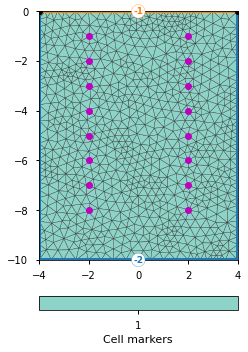

In [3]:
world = mt.createWorld(start=[-4, -10], end=[4, 0], worldMarker=True, marker=1)
for pos in data.sensorPositions():
    world.createNode(pos)

mesh = mt.createMesh(world, area=.1, quality=34, smooth=[1, 10])
ax, cb = pg.show(mesh, markers=True, showMesh=True)
ax.plot(pg.x(data), pg.y(data), "mo");

In [18]:
def plotABMN(ax, scheme, idx):
    """ Visualize four-point configuration on given axes. """
    def getABMN(scheme, idx):
        """ Get coordinates of four-point cfg with id `idx` from DataContainerERT
        `scheme`."""
        coords = {}
        for elec in "abmn":
            elec_id = int(scheme(elec)[idx])
            if elec_id >= 0:
                elec_pos = scheme.sensorPosition(elec_id)
                coords[elec] = elec_pos.x(), elec_pos.y()
        return coords
    
    coords = getABMN(scheme, idx)
    for elec in coords:
        x, y = coords[elec]
        if elec in "ab":
            color = "green"
        else:
            color = "magenta"
        ax.plot(x, y, marker=".", color=color, ms=10)
        ax.annotate(elec.upper(), xy=(x, y), size=12, ha="center", #fontsize=10, 
                    bbox=dict(boxstyle="round", fc=(0.8, 0.8, 0.8), ec=color), 
                    xytext=(20*np.sign(x), 0), textcoords='offset points', 
                    arrowprops=dict(arrowstyle="wedge, tail_width=.5", fc=color, ec=color,
                                    patchA=None, alpha=0.75))
        ax.plot(coords["a"][0],)

def showSensitivity(shm, mesh, idx=None, ax=None, nc=None):
    idx = idx or range(shm.size())
    nc = nc or len(idx)
    if ax is None:
        fig, ax = plt.subplots(len(idx)//nc, nc, sharex=True, sharey=True, figsize=(12, 8))

    fop = ert.ERTModelling(verbose=False)
    fop.setData(shm)
    fop.setMesh(mesh)
    model = np.ones(mesh.cellCount())
    fop.createJacobian(model)
    for i, ind in enumerate(idx):
        a = ax.flat[i]
        sens = fop.jacobian()[ind]
        normsens = pg.utils.logDropTol(sens/mesh.cellSizes(), 1e-2)
        normsens /= np.max(normsens)
        pg.show(mesh, normsens, cMap="bwr", colorBar=False, ax=a,
                        label="sensitivity", nLevs=3, cMin=-1, cMax=1)
        plotABMN(a, shm, ind);
        # a.set_xlim(-2, 12)
        # a.set_ylim(-5, 1)        

## Inhole arrays

In [5]:
# dipole-dipole, Wenner, Gradient
data.createFourPointData(data.size(), 0, 1, 2, 3)
data.createFourPointData(data.size(), 0, 1, 5, 6)
data.createFourPointData(data.size(), 0, 6, 2, 4)
data.createFourPointData(data.size(), 0, 7, 2, 3)
print(data)

Data: Sensors: 16 data: 4, nonzero entries: ['a', 'b', 'm', 'n', 'valid']


24/11/22 - 20:04:54 - pyGIMLi - INFO - Found 1 regions.
24/11/22 - 20:04:54 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/11/22 - 20:04:54 - pyGIMLi - INFO - Creating refined mesh (P2) to solve forward task.


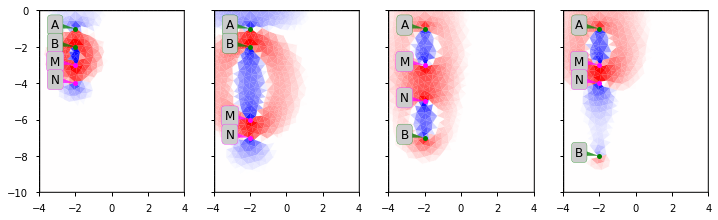

In [12]:
showSensitivity(data, mesh, range(4), nc=4)

Apparently the sensitivity structure is (almost) like for surface arrays, but mirrored.

## Cross-borehole: AB-MN

The two current electrodes are in one borehole and the two potential electodes are in the other.

In [7]:
data.createFourPointData(data.size(), 2, 6, 10, 14)
data.createFourPointData(data.size(), 2, 6, 12, 13)
data.createFourPointData(data.size(), 3, 4, 11, 12)
data.createFourPointData(data.size(), 0, 1, 14, 15)
print(data)

Data: Sensors: 16 data: 8, nonzero entries: ['a', 'b', 'k', 'm', 'n', 'valid']


24/11/22 - 20:05:01 - pyGIMLi - INFO - Found 1 regions.
24/11/22 - 20:05:01 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/11/22 - 20:05:01 - pyGIMLi - INFO - Creating refined mesh (P2) to solve forward task.


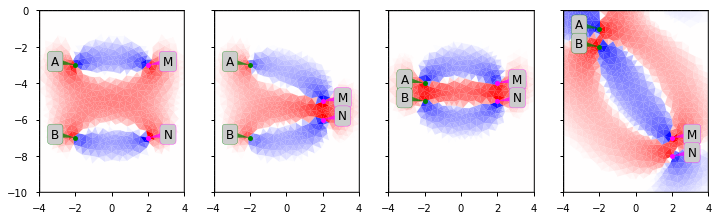

In [13]:
showSensitivity(data, mesh, range(4, 8), nc=4)

## Crosshole AM-BN

Here, a current and a potential electrode is in each of the boreholes.

In [9]:
data.createFourPointData(data.size(), 1, 9, 2, 10)
data.createFourPointData(data.size(), 1, 14, 2, 15)
data.createFourPointData(data.size(), 1, 12, 7, 13)
data.createFourPointData(data.size(), 1, 9, 6, 14)
print(data)

Data: Sensors: 16 data: 12, nonzero entries: ['a', 'b', 'k', 'm', 'n', 'valid']


24/11/22 - 20:05:06 - pyGIMLi - INFO - Found 1 regions.
24/11/22 - 20:05:06 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/11/22 - 20:05:06 - pyGIMLi - INFO - Creating refined mesh (P2) to solve forward task.


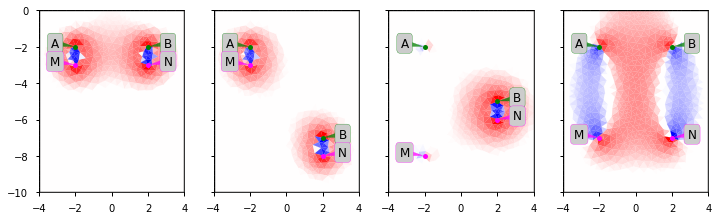

In [14]:
showSensitivity(data, mesh, range(8, 12), nc=4)

## Cross-borehole: AMN-B
Here, both potential electrodes are in the same hole with one current electrode.
Due to reciprocity, this is identical to MAB-N.

In [15]:
data.createFourPointData(data.size(), 1, 7, 8, 2)
data.createFourPointData(data.size(), 1, 8, 7, 2)
data.createFourPointData(data.size(), 1, 10, 3, 5)
data.createFourPointData(data.size(), 1, 4, 7, 10)
print(data)

Data: Sensors: 16 data: 16, nonzero entries: ['a', 'b', 'k', 'm', 'n', 'valid']


24/11/22 - 20:10:03 - pyGIMLi - INFO - Found 1 regions.
24/11/22 - 20:10:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/11/22 - 20:10:03 - pyGIMLi - INFO - Creating refined mesh (P2) to solve forward task.


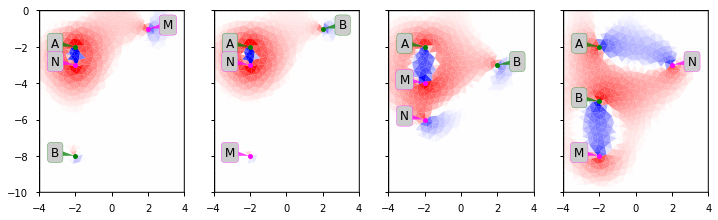

In [16]:
showSensitivity(data, mesh, range(12, 16), nc=4)

24/11/22 - 20:10:46 - pyGIMLi - INFO - Found 1 regions.
24/11/22 - 20:10:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/11/22 - 20:10:46 - pyGIMLi - INFO - Creating refined mesh (P2) to solve forward task.


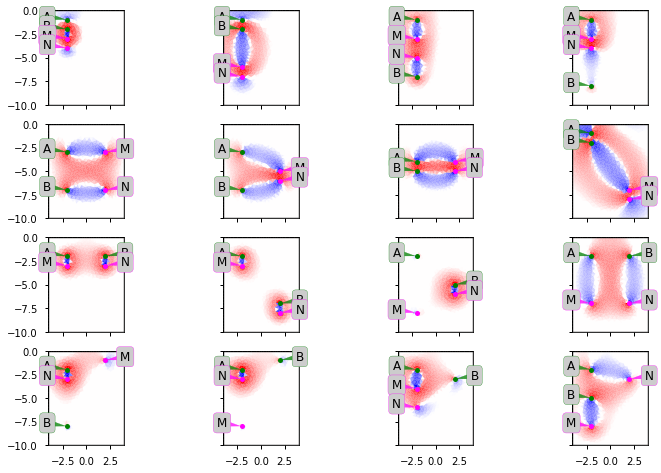

In [17]:
showSensitivity(data, mesh, nc=4)